# Блокнот №2.

### Введение

Данный блокнот иллюстрирует выполнение тестового задания №2 от NtechLab.

В этом блокноте мы продолжаем работу по созданию модели, способной определять пол человека по фотографии его лица. Предыдущая модель добилась точности свыше 97% на валидационном сете. При этом она была близка к 100% на тренировочном. Это свидетельствует об основной проблеме глубокого обучения - оверфиттинге.

Одним из стандартных решений этой проблемы для задач по классификации изображений является аугментация данных. Она включает в себя случайные повороты, обрезания, изменение размера, яркости, контрастности и прочие изменения. Эти операции я буду проводить только на тренировочном сете.

Возможно применение аугментации и на валидационном сете - например сделать несколько случайных изменений масштаба изображения, сделать общий прогноз и усреднить его. Я попробую применить этот подход после обучения модели. 


In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt
# Silencing tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_hub as hub

from sklearn.metrics import confusion_matrix
import pandas as pd

# Functions were introduced in previous notebook
import Gender_clf_utils as utils
# Check for GPU availability
print("GPU", "available!" if tf.config.list_physical_devices("GPU") else "not available")

GPU available!


In [2]:
data_dir = "./internship_data"
# Parameters setup
img_height, img_width = 96, 96
BATCH_SIZE = 32

### Аугментация изображений
У tf.keras имеется удобная функция для обработки изображений (но похоже случайное изменение яркости работает некорректно и пока я не буду его применять). Список изменений: поворот, изменение ширины и высоты, горизонтальное отражение, приближение. Далее я показал несколько обработанных изображений.

In [3]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    horizontal_flip=True,
    zoom_range=0.15,
    fill_mode="constant",
    cval=0, # Black padding
    validation_split = 0.2)

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split = 0.2)

In [4]:
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    seed=123, # same seed
    subset='training')

validation_generator = valid_datagen.flow_from_directory(
    data_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    seed=123, # same seed
    subset='validation')

Found 80002 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


Посмотрим на 10 тренировочных и 5 валидационных изображений (без изменений). 
Я выбрал параметр заполнения фона - константой, то есть черным цветом. Подобные черные зоны не вредят глубоким CNN.

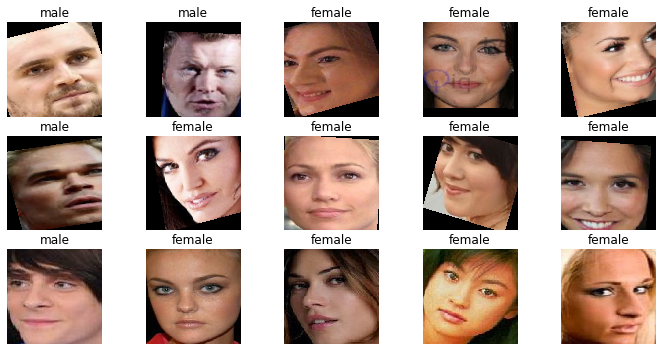

In [112]:
# Take one batch of images and labels
img, label = next(iter(train_generator))
vimg, vlabel = next(iter(validation_generator))

images = np.r_[img[0:10],vimg[0:5]].astype(int)
labels = np.r_[label[0:10],vlabel[0:5]]
utilites.plot_images(images, labels, class_names=["female", "male"])

Так как эти случайные изменения будут происходить каждую эпоху, они точно не дадут модели выучить тренировочный сет. Но и обучить модель будет гораздо сложнее. Поэтому я увеличил её размер.

Далее мы во многом повторяем код из прошлого блокнота, т.е. импортируем обученную модель с tf.hub и сначала тренируем только верхний слой, затем всю модель.

Перечислю основные изменения:

* Так как задача стала сложнее, я решил увеличить модель. Теперь мы используем 100% версию mobilenet_v2 вместо 35%. 

* После разморозки всех слоев, я ещё больше снизил начальную скорость обучения, что бы не навредить более чувствительной модели (из-за её большего размера). 

* Увеличил количество эпох до 40. (Далее продолжил ещё 10 эпох)

In [75]:
# Links to model for loading
handle_base = "mobilenet_v2_100_96"
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
print("Using {} with input size {}".format(MODULE_HANDLE, (img_height, img_width)))

Using https://tfhub.dev/google/imagenet/mobilenet_v2_100_96/feature_vector/4 with input size (96, 96)


In [76]:
# Loaded part of the model
base_model = hub.KerasLayer(MODULE_HANDLE, trainable=False)

inputs = layers.Input(shape=(img_height, img_width, 3))
# Normalization of inputs
x = layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = base_model(x, training=False)
x = layers.Dropout(rate=0.2)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

mobilev2_model = tf.keras.Model(inputs, outputs)

mobilev2_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 96, 96, 3)         0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [83]:
# Learning
mobilev2_model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.05, momentum=0.9, decay=0.01), 
  loss=tf.keras.losses.BinaryCrossentropy(),
  metrics=['accuracy'])

freezed_history = mobilev2_model.fit(
  train_generator,
  validation_data=validation_generator,
  epochs=15,
  verbose=1
)

Epoch 1/15
2501/2501 [==============================] - 2824s 1s/step - loss: 0.5761 - accuracy: 0.8185 - val_loss: 0.3496 - val_accuracy: 0.8490
Epoch 2/15
2501/2501 [==============================] - 346s 138ms/step - loss: 0.3684 - accuracy: 0.8429 - val_loss: 0.3345 - val_accuracy: 0.8539
Epoch 3/15
2501/2501 [==============================] - 302s 121ms/step - loss: 0.3565 - accuracy: 0.8466 - val_loss: 0.3684 - val_accuracy: 0.8333
Epoch 4/15
2501/2501 [==============================] - 302s 121ms/step - loss: 0.3491 - accuracy: 0.8494 - val_loss: 0.3299 - val_accuracy: 0.8568
Epoch 5/15
2501/2501 [==============================] - 302s 121ms/step - loss: 0.3456 - accuracy: 0.8511 - val_loss: 0.3304 - val_accuracy: 0.8553
Epoch 6/15
2501/2501 [==============================] - 302s 121ms/step - loss: 0.3468 - accuracy: 0.8508 - val_loss: 0.3338 - val_accuracy: 0.8521
Epoch 7/15
2501/2501 [==============================] - 303s 121ms/step - loss: 0.3462 - accuracy: 0.8515 - val_lo

In [ ]:
np.save('histories/freezed_history', freezed_history.history)

# Saving model
model_path = "./models/mobilev2_full_top_15ep"
mobilev2_model.save(model_path)

In [18]:
# Unfreeze loaded weights
base_model.trainable = True
mobilev2_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 96, 96, 3)         0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 2,225,153
Non-trainable params: 34,112
_________________________________________________________________


In [6]:
# Creating callbacks and learning schedule
def one_cycle_scheduler(mid_epoch=14, growth=1.6, decay=-0.1):
    def schedule(epoch, lr):
        if epoch < mid_epoch:
            return growth * lr
        else:
            return lr * tf.math.exp(decay)
    return schedule

tensorboard = tf.keras.callbacks.TensorBoard("./logs/mobilev2_1")
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=8, 
                                                 restore_best_weights=True)
schedule_func = one_cycle_scheduler()
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(
    schedule_func, verbose=1)

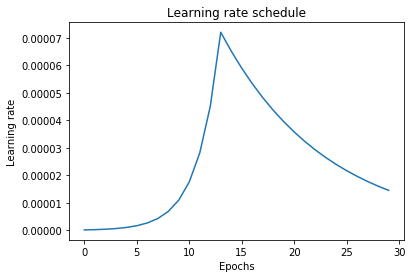

In [127]:
# learning schedule
lr = 1e-7
lrs = []
for epoch in range(30):
    lr = schedule_func(epoch, lr)
    lrs.append(lr)
plt.plot(range(30), lrs)
plt.xlabel("Epochs")
plt.ylabel("Learning rate")
plt.title("Learning rate schedule");

Конечно, RMSprop является адаптивным оптимизатором, и lr параметр не определяет точную скорость обучения, но я все равно применяю расписание, чтобы контролировать скорость изменений.

In [88]:
mobilev2_model.compile(
  optimizer=tf.keras.optimizers.RMSprop(lr=1e-7),
  loss=tf.keras.losses.BinaryCrossentropy(),
  metrics=['accuracy'])

epochs = 40
# Training
mobilev2_full_history = mobilev2_model.fit(
  train_generator,
  validation_data=validation_generator,
  epochs=epochs,
  callbacks=[tensorboard, early_stopping, lr_scheduler],
  verbose=1
)


Epoch 00001: LearningRateScheduler reducing learning rate to 1.600000018697756e-07.
Epoch 1/40
   1/2501 [..............................] - ETA: 0s - loss: 0.5617 - accuracy: 0.7812WARNING:tensorflow:From F:\Programming\AnacondaN\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


Instructions for updating:
use `tf.profiler.experimental.stop` instead.


   2/2501 [..............................] - ETA: 22:18 - loss: 0.4820 - accuracy: 0.8125WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1371s vs `on_train_batch_end` time: 0.9348s). Check your callbacks.


2501/2501 [==============================] - 321s 128ms/step - loss: 0.4012 - accuracy: 0.8595 - val_loss: 0.3931 - val_accuracy: 0.8594

Epoch 00002: LearningRateScheduler reducing learning rate to 2.5599999844416746e-07.
Epoch 2/40
2501/2501 [==============================] - 319s 127ms/step - loss: 0.3769 - accuracy: 0.8734 - val_loss: 0.3570 - val_accuracy: 0.8786

Epoch 00003: LearningRateScheduler reducing learning rate to 4.095999884157209e-07.
Epoch 3/40
2501/2501 [==============================] - 317s 127ms/step - loss: 0.3481 - accuracy: 0.8850 - val_loss: 0.3336 - val_accuracy: 0.8910

Epoch 00004: LearningRateScheduler reducing learning rate to 6.553599632752594e-07.
Epoch 4/40
2501/2501 [==============================] - 315s 126ms/step - loss: 0.3222 - accuracy: 0.8975 - val_loss: 0.2944 - val_accuracy: 0.9100

Epoch 00005: LearningRateScheduler reducing learning rate to 1.048575904860627e-06.
Epoch 5/40
2501/2501 [==============================] - 313s 125ms/step - loss

2501/2501 [==============================] - 324s 130ms/step - loss: 0.0869 - accuracy: 0.9842 - val_loss: 0.1092 - val_accuracy: 0.9790

Epoch 00035: LearningRateScheduler reducing learning rate to tf.Tensor(8.823906e-06, shape=(), dtype=float32).
Epoch 35/40
2501/2501 [==============================] - 339s 136ms/step - loss: 0.0855 - accuracy: 0.9851 - val_loss: 0.1006 - val_accuracy: 0.9804

Epoch 00036: LearningRateScheduler reducing learning rate to tf.Tensor(7.984199e-06, shape=(), dtype=float32).
Epoch 36/40
2501/2501 [==============================] - 336s 134ms/step - loss: 0.0862 - accuracy: 0.9850 - val_loss: 0.1005 - val_accuracy: 0.9796

Epoch 00037: LearningRateScheduler reducing learning rate to tf.Tensor(7.224402e-06, shape=(), dtype=float32).
Epoch 37/40
2501/2501 [==============================] - 319s 128ms/step - loss: 0.0848 - accuracy: 0.9853 - val_loss: 0.1025 - val_accuracy: 0.9807

Epoch 00038: LearningRateScheduler reducing learning rate to tf.Tensor(6.536909

In [89]:
np.save('histories/augmented_full_history', mobilev2_full_history.history)

# Saving model
model_path = "./models/mobilev2_full_40ep"
mobilev2_model.save(model_path)

INFO:tensorflow:Assets written to: ./models/mobilev2_full_40ep\assets


INFO:tensorflow:Assets written to: ./models/mobilev2_full_40ep\assets


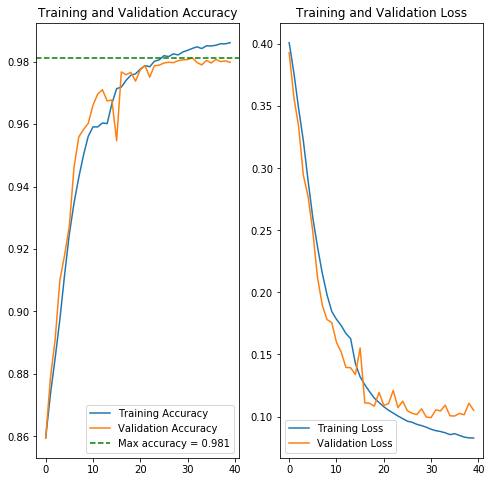

In [113]:
utils.plot_histories(mobilev2_full_history.history, 40)

Похоже модель затрудняется достигнуть 99% как на тренировочном, так и на валидационном сете. Оверфит выражен неявно.
Попробуем продолжить обучение. Учитывая сложность и рандомность аугментированного датасета, я не слишком опасаюсь оверфиттинга. 
Изменим оптимизатор на Adam. Обычно он ещё менее требователен к выбору lr параметра.

In [6]:
# Loading model if session were interrupted
# mobilev2_model = tf.keras.models.load_model('./models/mobilev2_full_40ep')

In [26]:
mobilev2_model.compile(
  optimizer=tf.keras.optimizers.Adam(lr=1e-6),
  loss=tf.keras.losses.BinaryCrossentropy(),
  metrics=['accuracy'])

epochs = 10
# Training
mobilev2_full_history_40_50 = mobilev2_model.fit(
  train_generator,
  validation_data=validation_generator,
  epochs=epochs,
  callbacks=[tensorboard, early_stopping],
  verbose=1
)

Epoch 1/10
2501/2501 [==============================] - 347s 139ms/step - loss: 0.0822 - accuracy: 0.9859 - val_loss: 0.0966 - val_accuracy: 0.9811
Epoch 2/10
2501/2501 [==============================] - 328s 131ms/step - loss: 0.0814 - accuracy: 0.9860 - val_loss: 0.0957 - val_accuracy: 0.9809
Epoch 3/10
2501/2501 [==============================] - 344s 138ms/step - loss: 0.0806 - accuracy: 0.9865 - val_loss: 0.0959 - val_accuracy: 0.9814
Epoch 4/10
2501/2501 [==============================] - 351s 140ms/step - loss: 0.0817 - accuracy: 0.9855 - val_loss: 0.0953 - val_accuracy: 0.9812
Epoch 5/10
2501/2501 [==============================] - 340s 136ms/step - loss: 0.0809 - accuracy: 0.9860 - val_loss: 0.0962 - val_accuracy: 0.9812
Epoch 6/10
2501/2501 [==============================] - 342s 137ms/step - loss: 0.0799 - accuracy: 0.9863 - val_loss: 0.0963 - val_accuracy: 0.9815
Epoch 7/10
2501/2501 [==============================] - 352s 141ms/step - loss: 0.0822 - accuracy: 0.9858 - val_

In [ ]:
#np.save('histories/augmented_full_history_40_50', mobilev2_full_history_1.history)

# Saving model
model_path = "./models/mobilev2_full_50ep"
mobilev2_model.save(model_path)

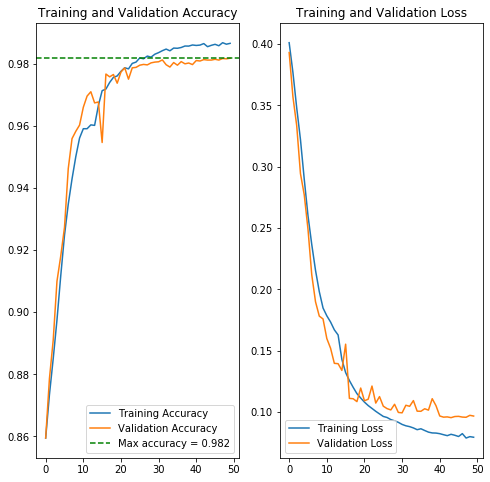

In [32]:
# Connecting two histories

h1 = mobilev2_full_history.history
h2 = mobilev2_full_history_40_50.history
for key in h1:
    if key != "lr":
            h1[key].extend(h2[key])
            
utils.plot_histories(h1, 50)

После смены оптимизатора и отказа от расписания обучения, процесс пошел намного плавнее. Похоже, что мы получили небольшую прибавку в точности.

Идеи для дальнейшего улучшения результатов: 
* Дать модели обучиться ещё. Также попробовать разные оптимизаторы.
* Изменить аугментацию: добавить шум, возможно уменьшить поворот и зум.
* Взять модель с другой архитектурой.

## Анализ ошибок
Повторим код из прошлого блокнота и посмотрим на изображения, которые были классифированы некорректно.

In [14]:
# Loading model if session were interrupted
# mobilev2_model = tf.keras.models.load_model('./models/mobilev2_full_50ep')

In [105]:
valid_dataset = tf.data.Dataset.from_generator(lambda: validation_generator,
                                               (tf.float32, tf.float32))
images, labels = utils.unbatchify(valid_dataset, max_size=1000)
predictions = mobilev2_model.predict(images).squeeze()

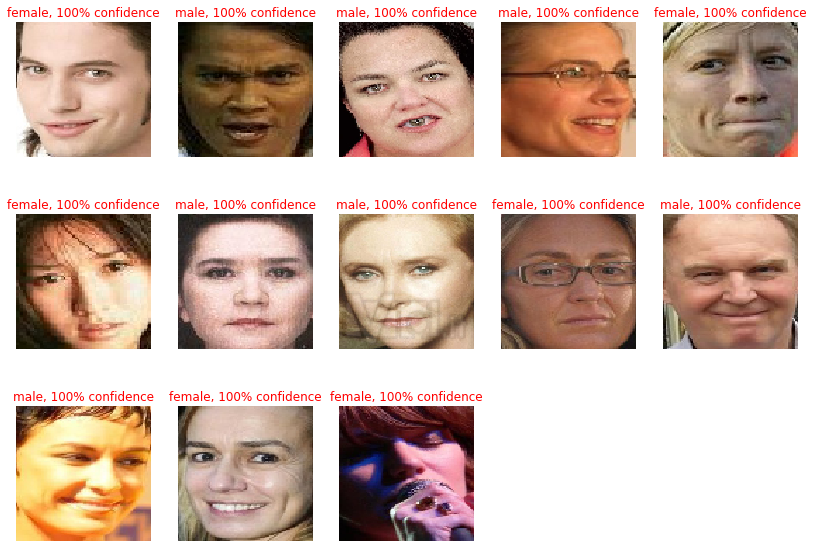

In [108]:
mistakes_mask = np.round(predictions) != labels
utils.plot_images(images[mistakes_mask], 
                 predictions[mistakes_mask], 
                 labels[mistakes_mask], 
                 class_names=["female", "male"],
                 figsize=(14,10), n_cols=5)

In [107]:
# confusion matrix
y_true, y_pred = labels, np.round(predictions)
conf_matr = confusion_matrix(y_true, y_pred)
# Beautification
df_cm = pd.DataFrame(conf_matr, index=["True_Female", "True_Male"], 
                     columns=["Pred_Female", "Pred_Male"])
df_cm

,Pred_Female,Pred_Male
True_Female,483,6
True_Male,7,504


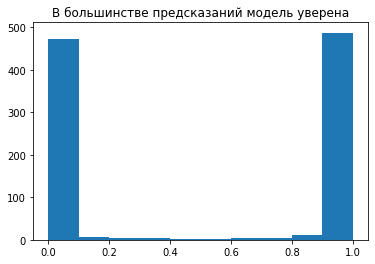

In [124]:
plt.hist(predictions, bins=10, label=counts)
plt.title("В большинстве предсказаний модель уверена");

Некоторые ошибки опять вызывают сомнения в корректности данных. Так как наш генератор данных перемешивает изображения, я не могу вернуть названия файлов, чтобы перепроверить, точно ли это ошибки данных. 

Попробую взять выборку из путей к файлам и посмотреть на прогнозы для этих изображений. 
Конечно, таким образом я смешиваю тренировочный и валидационный сет и анализировать ошибки на такой выборке нельзя. Но для проверки данных меня этот подход устраивает.

In [129]:
# Taking sample of 1000 images
image_paths = []
for folder in ["internship_data/female", "internship_data/male"]:
    rand_folder = np.random.randint(0,400)# each has 100 images
    subfolders = os.listdir(folder)[rand_folder: rand_folder+5]
    for i in range(5):
        # Since I put images in subfolders I make double listdir
        image_names = os.listdir(os.path.join(folder, 
                                                subfolders[i]))
        images_path = os.path.join(folder, subfolders[i])
        for name in image_names:
            image_paths.append(os.path.join(images_path, name))
# 500 females, 500 males. Unshuffled
labels_sample = np.array([0]*500 + [1]*500)
print("samle size", len(image_paths))

samle size 1000


In [133]:
def process_image(image_path):
  """
  Takes image path and returns reshaped tensor
  """
  image = tf.io.read_file(image_path) 
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, size=[96, 96])
  return image

# Creating dataset
ds = tf.data.Dataset.from_tensor_slices((image_paths, labels_sample))
ds = ds.map(lambda x,y: (process_image(x), y)).batch(32)

# Taking data and making predictions
images_sampled, labels_sampled = utils.unbatchify(ds, max_size=1000)
preds_sampled = mobilev2_model.predict(images_sampled).squeeze()

['internship_data/female\\images_0259\\105095.jpg'
 'internship_data/female\\images_0259\\105307.jpg'
 'internship_data/female\\images_0261\\106126.jpg'
 'internship_data/female\\images_0262\\106451.jpg'
 'internship_data/female\\images_0262\\106613.jpg'
 'internship_data/male\\images_0337\\136053.jpg'
 'internship_data/male\\images_0337\\136209.jpg'
 'internship_data/male\\images_0337\\136215.jpg'
 'internship_data/male\\images_0337\\136278.jpg'
 'internship_data/male\\images_0339\\137011.jpg'
 'internship_data/male\\images_0339\\137165.jpg'
 'internship_data/male\\images_0340\\137287.jpg'
 'internship_data/male\\images_0341\\137708.jpg'
 'internship_data/male\\images_0341\\137937.jpg']


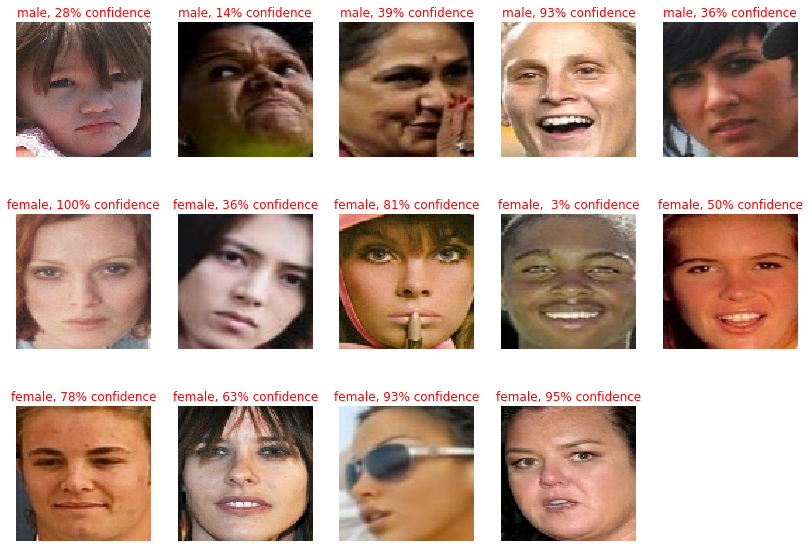

In [104]:
mistakes_mask = np.round(preds_sampled) != labels_sampled
utils.plot_images(images_sampled[mistakes_mask],  
                 labels_sampled[mistakes_mask], 
                 preds_sampled[mistakes_mask],
                 class_names=["female", "male"],
                 figsize=(14,10), n_cols=5)
print(np.array(image_sample)[mistakes_mask])

Нижние два ряда картинок содержат только "мужчин". На мой вгляд, некоторые из них могут являться женщинами, и возможно были допущены ошибки при разметке данных. Неудивительно, что модель затруднилась их классифицировать. Я проверил местонахождение изображений, эти файлы действительно находятся в папке с мужчинами.

Учитывая это, возможно наша модель даже немного лучше, чем показывают графики обучения. Я предполагаю, что она может приблизится к 99% при обучении на корректном датасете.

### Аугментация валидационного сета. 
Проведем последний эксперимент в данном блокноте. 

Из каждого изображения мы вырежем 9 различных частей (немногим меньше самого изображения) и вернем их размер (растянем) к исходному. После этого усредним предсказания модели или воспользуемся голосованием. Сравним оба подхода.

In [300]:
def make_cropped_images(image, n=3):
    """
    Takes image and returns batch of images n**2 size of its cropped variants
    """
    image = tf.expand_dims(image, 0)
    boxes = np.array([[0+i*0.1, 0+j*0.1, 1-i*0.1, 1-j*0.1] for i in range(n) for j in range(n)])
    box_indices = [0] * n**2
    cropped_images = tf.image.crop_and_resize(image, boxes, box_indices, (96,96))    
    return cropped_images
    
def augmented_prediction(model, images):
    """
    Takes model and array of images
    Returns two arrays: first is 
    """
    # For convenient map form dataset again
    dataset = tf.data.Dataset.from_tensor_slices(images)
    dataset = dataset.map(lambda x: make_cropped_images(x))
    # Making predictions
    all_preds = model.predict(dataset).squeeze()
    unaug_preds = model.predict(images).squeeze()
    return all_preds, unaug_preds

# Taking sample
images, labels = utils.unbatchify(valid_dataset, max_size=1000)
# Predictions
aug_preds, unaug_preds = augmented_prediction(mobilev2_model, images)

In [301]:
# Summing all predictions and averaging them
preds_avg = np.round(aug_preds.reshape(-1, 9).sum(axis=1) / 9)
# Counting votes for each class and return one with majority
rounded_preds = np.round(aug_preds).reshape(-1, 9).sum(axis=1)
preds_voting = np.where(rounded_preds < 5, 0., 1.)

corr_avg = (preds_avg.astype(int) == labels).sum()
corr_vote = (preds_voting.astype(int) == labels).sum()
corr_normal = (np.round(unaug_preds).astype(int) == labels).sum()
print("Correct without augmentation:", corr_normal)
print("Correct using voting:", corr_vote)
print("Correct using averaging:", corr_normal)

Correct without augmentation: 976
Correct using voting: 973
Correct using averaging: 976


В данном случае, такая аугментация валидационного сета (cropping) не дает улучшения результатов. Возможно стоит рассмотреть другие варианты аугментации. 

### Заключение

Аугментация изображений действительно позволила справится с проблемой оверфиттинга. Но за время обучения модель не смогла достигнуть 100% точности на таком сложном датасете. В итоге мы получили лишь небольшую прибавку в точности (с 97.5% до 98%).
Но мы обнаружили и подтвердили возможную проблему обучения - это наличие данных, которые могут запутать модель. В папках с одним полом, имеются изображения с лицами явно принадлежащими другому. Хоть я и не могу проверить корректность разметки, стоит отметить наличие подобных аномалий в реальной жизни. Но в данном случае они скорее мешают процессу обучения, так как модель учится на вторичных половых признаках.
Также проверив возможность аугментации изображений перед их классификацией, я решил не применять данный подход.

Финальная версия обучения модели с нуля размещена в файле train.py. Инструкция по использованию находится в readme на github.
Отличия обучения в финальной версии от этого блокнота: 
* Обучение проводится на всем датасете, без валидации.
* Тренировка верхнего слоя длится только 10 эпох, вместо 15.
* Далее вся модель тренируется 40 эпох с оптимизатором Adam и разогревочным расписанием обучения (начинается с малого значения, постепенно достигая максимального и оставаясь на нем)
